# Exploratory Analysis of Spatial Data: Spatial Autocorrelation #

The earlier notebooks provided several illustrations of the power of
visualization in the analysis of spatial data. This power stems from
visualizations ability to tap into our human pattern recognition machinery.

In this notebook we introduce methods of _exploratory spatial data analysis_
that are intended to complement geovizualization through formal univariate and
multivariate statistical tests for spatial clustering.


## Imports

In [1]:
import pandas as pd
import geopandas as gpd
import libpysal as lp
import matplotlib.pyplot as plt
import rasterio as rio
import numpy as np
import contextily as ctx
import shapely.geometry as geom
%matplotlib inline

In [2]:
df = gpd.read_file('data/neighborhoods.gpkg')
listings = gpd.read_file('data/listings.gpkg')
listings['price'] = listings.price.str.replace('$', '').str.replace(',','_').astype(float)
# was created in previous notebook with df.to_file('data/neighborhoods.gpkg')

In [3]:
median_price = gpd.sjoin(listings[['price', 'geometry']], df, op='within')\
                  .groupby('index_right').price.median()
df['median_pri'] = median_price.values

In [4]:
df.head()

,hood_id,hood_group,geometry,median_pri
0,78739,None,"(POLYGON ((-97.890016 30.209412, -97.889286 30...",150.0
1,78754,None,"(POLYGON ((-97.636577 30.402658, -97.637538000...",75.0
2,78732,None,"(POLYGON ((-97.87302800000001 30.438064, -97.8...",249.0
3,78737,None,"(POLYGON ((-98.018756 30.241665, -98.016169 30...",135.0
4,78756,None,"(POLYGON ((-97.72792200000001 30.329055, -97.7...",107.5


In [5]:
pd.isnull(df['median_pri']).sum()

0

In [6]:
df = df
df['median_pri'].fillna((df['median_pri'].mean()), inplace=True)


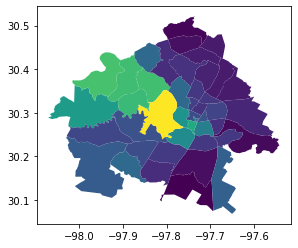

In [7]:
df.plot(column='median_pri')

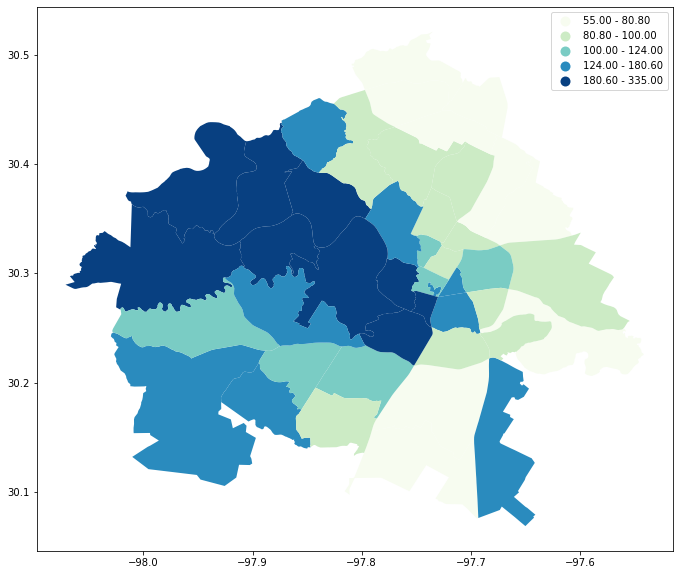

In [8]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
df.plot(column='median_pri', scheme='Quantiles', k=5, cmap='GnBu', legend=True, ax=ax)
#ax.set_xlim(150000, 160000)
#ax.set_ylim(208000, 215000)

## Spatial Autocorrelation ##

Visual inspection of the map pattern for the prices allows us to search for
spatial structure. If the spatial distribution of the prices was random, then we
should not see any clustering of similar values on the map. However, our visual
system is drawn to the darker clusters in the south west as well as the center,
and a concentration of the lighter hues (lower prices) in the north central and
south east.

Our brains are very powerful pattern recognition machines. However, sometimes
they can be too powerful and lead us to detect false positives, or patterns
where there are no statistical patterns. This is a particular concern when
dealing with visualization of irregular polygons of differning sizes and shapes.

The concept of *spatial
autocorrelation* relates to the combination of two types of similarity: spatial
similarity and attribute similarity. Although there are many different measures
of spatial autocorrelation, they all combine these two types of simmilarity into
a summary measure.

Let's use PySAL to generate these two types of similarity
measures.

### Spatial Similarity ###

We have already encountered spatial weights
in a previous notebook. In spatial autocorrelation analysis, the spatial weights
are used to formalize the notion of spatial similarity. As we have seen there
are many ways to define spatial weights, here we will use queen contiguity:

In [9]:
wq =  lp.weights.Queen.from_dataframe(df)
wq.transform = 'r'

### Attribute Similarity ###

So the spatial weight between neighborhoods $i$ and $j$ indicates if the two 
are neighbors (i.e., geographically similar). What we also need is a measure of
attribute similarity to pair up with this concept of spatial similarity. The
**spatial lag** is a derived variable that accomplishes this for us. For neighborhood
$i$ the spatial lag is defined as: $$y_i = \sum_j w_{i,j} y_j$$

In [10]:
y = df['median_pri']
ylag = lp.weights.lag_spatial(wq, y)

In [11]:
ylag

array([115.        ,  92.5       , 221.6       , 128.33333333,
       112.9       ,  98.33333333, 112.5       , 172.5       ,
       197.6       , 111.        , 101.33333333,  70.        ,
       112.66666667, 147.25      , 125.27777778, 132.3125    ,
        80.        , 119.375     , 137.        , 203.7       ,
        77.33333333, 119.5       , 203.08333333, 114.83333333,
       162.1875    ,  98.4       ,  79.6       ,  91.4375    ,
        88.5       , 165.875     ,  85.        , 156.625     ,
        89.6       , 193.08333333,  94.58333333, 196.33333333,
       233.6       , 101.5625    , 121.35714286, 187.85714286,
       111.7       ,  80.66666667, 229.        , 154.85714286])

In [12]:
import mapclassify as mc
ylagq5 = mc.Quantiles(ylag, k=5)

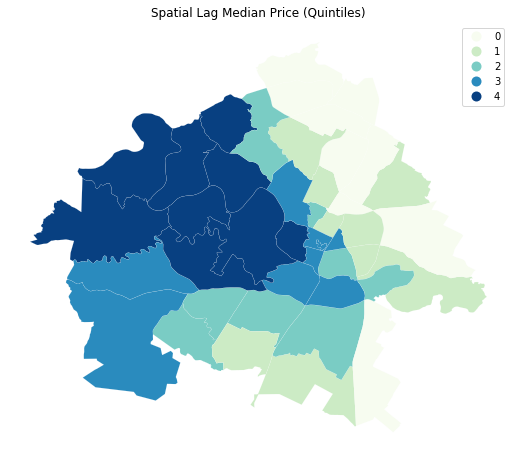

In [13]:
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=ylagq5.yb).plot(column='cl', categorical=True, \
        k=5, cmap='GnBu', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Spatial Lag Median Price (Quintiles)")

plt.show()

The quintile map for the spatial lag tends to enhance the impression of value
similarity in space. It is, in effect, a local smoother.

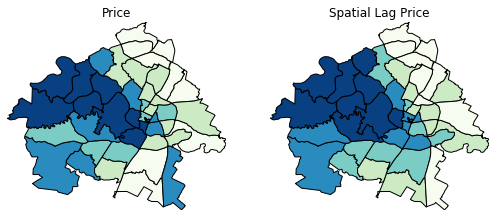

In [14]:
df['lag_median_pri'] = ylag
f,ax = plt.subplots(1,2,figsize=(2.16*4,4))
df.plot(column='median_pri', ax=ax[0], edgecolor='k',
        scheme="quantiles",  k=5, cmap='GnBu')
ax[0].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Price")
df.plot(column='lag_median_pri', ax=ax[1], edgecolor='k',
        scheme='quantiles', cmap='GnBu', k=5)
ax[1].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag Price")
ax[0].axis('off')
ax[1].axis('off')
plt.show()

However, we still have
the challenge of visually associating the value of the prices in a neighborhod
with the value of the spatial lag of values for the focal unit. The latter is a
weighted average of homicide rates in the focal county's neighborhood.

To complement the geovisualization of these associations we can turn to formal
statistical measures of spatial autocorrelation.


## Global Spatial Autocorrelation

We begin with a simple case where the variable under consideration is binary.
This is useful to unpack the logic of spatial autocorrelation tests. So  even though
our attribute is a continuously valued one, we will convert it to a binary case
to illustrate the key concepts:

### Binary Case

In [15]:
y.median()


109.25

In [16]:
yb = y > y.median()
sum(yb)

22

We have 22 neighborhoods with list prices above the median and the remainder below the
median (recall the issue with ties).

In [17]:
yb = y > y.median()
labels = ["0 Low", "1 High"]
yb = [labels[i] for i in 1*yb] 
df['yb'] = yb

The spatial distribution of the binary variable immediately raises questions
about the juxtaposition of the "black" and "white" areas.

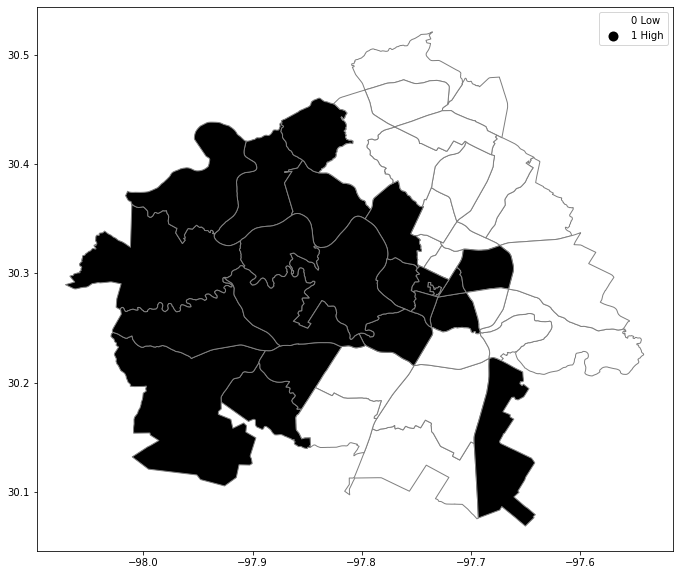

In [18]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
df.plot(column='yb', cmap='binary', edgecolor='grey', legend=True, ax=ax)

### Join counts ###

One way to formalize a test for spatial autocorrelation in a binary attribute is
to consider the so-called _joins_. A join exists for each neighbor pair of
observations, and the joins are reflected in our binary spatial weights object
`wq`. 

Each unit can take on one of two values "Black" or "White", and so for a given
pair of neighboring locations there are three different types of joins that can
arise:

- Black Black (BB)
- White White (WW)
- Black White (or White Black) (BW)

Given that we have 68 Black polygons on our map, what is the number of Black
Black (BB) joins we could expect if the process were such that the Black
polygons were randomly assigned on the map? This is the logic of join count statistics.

We can use the `esda` package from PySAL to carry out join count analysis:

In [19]:
import esda 
yb = 1 * (y > y.median()) # convert back to binary
wq =  lp.weights.Queen.from_dataframe(df)
wq.transform = 'b'
np.random.seed(12345)
jc = esda.join_counts.Join_Counts(yb, wq)

The resulting object stores the observed counts for the different types of joins:

In [20]:
jc.bb

44.0

In [21]:
jc.ww

43.0

In [22]:
jc.bw

32.0

Note that the three cases exhaust all possibilities:

In [23]:
jc.bb + jc.ww + jc.bw

119.0

and

In [24]:
wq.s0 / 2

119.0

which is the unique number of joins in the spatial weights object.

Our object tells us we have observed 44 BB joins:

In [25]:
jc.bb

44.0

The critical question for us, is whether this is a departure from what we would
expect if the process generating the spatial distribution of the Black polygons
were a completely random one? To answer this, PySAL uses random spatial
permutations of the observed attribute values to generate a realization under
the null of _complete spatial randomness_ (CSR). This is repeated a large number
of times (999 default) to construct a reference distribution to evaluate the
statistical significance of our observed counts.

The average number of BB joins from the synthetic realizations is:

In [26]:
jc.mean_bb

28.91791791791792

which is less than our observed count. The question is whether our observed
value is so different from the expectation that we would reject the null of CSR?

Text(0.5, 0, 'BB Counts')

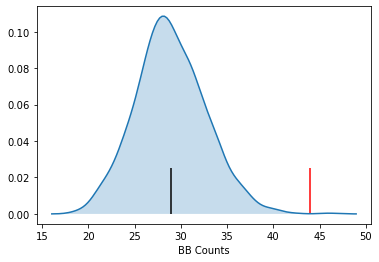

In [27]:
import seaborn as sbn
sbn.kdeplot(jc.sim_bb, shade=True)
plt.vlines(jc.bb, 0, 0.025, color='r')
plt.vlines(jc.mean_bb, 0, 0.025)
plt.xlabel('BB Counts')


The density portrays the distribution of the BB counts, with the black vertical
line indicating the mean BB count from the synthetic realizations and the red
line the observed BB count for our prices. Clearly our observed value is
extremely high. A pseudo p-value summarizes this:

In [28]:
jc.p_sim_bb


0.002

Since this is below conventional significance levels, we would reject the null
of complete spatial randomness in favor of spatial autocorrelation in market prices.


### Continuous Case

The join count analysis is based on a binary attribute, which can cover many
interesting empirical applications where one is interested in presence and
absence type phenomena. In our case, we artificially created the binary variable,
and in the process we throw away a lot of information in our originally
continuous attribute. Turning back to the original variable, we can explore
other tests for spatial autocorrelation for the continuous case.

First, we transform our weights to be row-standardized, from the current binary state:

In [29]:
wq.transform = 'r'

In [30]:
y = df['median_pri']

Moran's I is a test for global autocorrelation for a continuous attribute:

In [31]:
np.random.seed(12345)
mi = esda.moran.Moran(y, wq)
mi.I

0.5957727139423782

Again, our value for the statistic needs to be interpreted against a reference
distribution under the null of CSR. PySAL uses a similar approach as we saw in
the join count analysis: random spatial permutations.

Text(0.5, 0, "Moran's I")

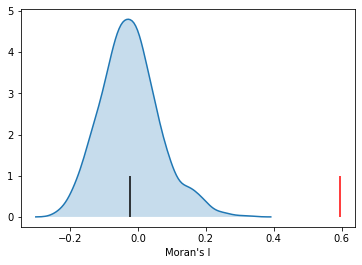

In [32]:
import seaborn as sbn
sbn.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 1, color='r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")


Here our observed value is again in the upper tail, although visually it does
not look as extreme relative to the binary case. Yet, it is still statistically significant:

In [33]:
mi.p_sim

0.001

We will save our derived variables in a  file for use in later notebooks:

In [34]:
df.to_file("data/airbnb.shp")